In [1]:
import numpy as np
from random import randrange
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from scipy.stats import multivariate_normal

In [170]:
class GMM:
    """
    Guassian Mixture Model implementation for 2-d continuous data.
    """
    def __init__(self, max_iter, tol):
        self.max_iter = max_iter # max number of times to run EM algo
        self.tol = tol # convergence is acheived if delta_loglikelihood <= tolerance
        self.x1 = None
        self.x2 = None
        self.k = None
        self.log_likelihood = None
        self.means = None
        self.covariances = None
        self.w = None
        self.p = None
        self.converged = False
        
    def _update_probabilities(self,):
        """
        E Step: where probabilities of each sample belonging to on of k distributions is 
        calculated based on the current parameters
        """
        for i in range(self.k):
            likelihood = multivariate_normal(self.means[i], self.covariances[i]).pdf(np.vstack((self.x1,self.x2)).T) 
            self.p[:,i] = self.w[i] * likelihood
        self.p = self.p/np.sum(self.p, axis=1, keepdims=True)
        
    def _update_parameters(self,):
        """
        M Step: where parameters get updated.
        """
        self.w = np.sum(self.p,axis=0) / len(self.x2) # percentage of samples belonging to each of k distribtions
        self.means = np.dot(self.p.T,np.vstack((self.x1,self.x2)).T) / np.vstack(np.sum(self.p,axis=0))
        for i in range(self.k):
            dist = np.vstack((self.x1,self.x2)).T - self.means[i]
            self.covariances[i] = np.dot(self.p[:,i]*dist.T,dist) / np.sum(self.p,axis=0)[i]
                
    def _get_loglikelihood(self):
        weights_times_likelihoods = np.zeros((len(self.x1),self.k))
        for i in range(self.k):
            likelihood = multivariate_normal(self.means[i], self.covariances[i]).pdf(np.vstack((self.x1,self.x2)).T) 
            weights_times_likelihoods[:,i] = self.w[i] * likelihood
        self.log_likelihood = - np.sum(np.log(np.sum(weights_times_likelihoods,axis=1)))
        return self.log_likelihood
        
    def cluster(self, k, x1, x2):
        self.x1 = x1
        self.x2 = x2
        self.k = k # number of "clusters" (guassian distributions)
        
        # initialize means randomily choosing first center and picking points furthest from other centers
        idx = randrange(len(x1))
        means = [np.array([x1[idx],x2[idx]])]
        for i in range(2,k+1):
            D = []
            for j in range(0,len(x1)):
                D_j_arr = []
                for mu in means:
                    D_j_arr.append((x1[j]-mu[0])**2 + (x2[j]-mu[1])**2)
                D.append(min(D_j_arr))
            idx_mu = np.argmax(D)
            means.append(np.array([x1[idx_mu],x2[idx_mu]]))
        self.means = means
        
        # initialize the covariance matrices to be the covariance of all the data
        # note: there are k cov matrices of dim 2x2 because we are exlusively dealing with 2-d continuous datasets
        self.covariances = np.full((k,2,2), np.cov(np.vstack((x1,x2)).T, rowvar = False))
        
        # initialize the weights to be 1/k for all k clusters
        self.w = np.ones(k)/k
        
        # initialize the probabilites an observation belongs to a given cluster
        self.p = np.ones((len(x1),k))/k
            
        prev_loglikelihood, new_loglikelihood = 0,0
        for i in range(self.max_iter):
            # E-step
            self._update_probabilities()
            # M-step
            self._update_parameters()
            # Check for convergence (delta_log_likelikhood <= tol)
            new_log_likelihood = self._get_loglikelihood()
            delta_log_likelihood = prev_loglikelihood - new_loglikelihood 
            if(abs(delta_log_likelihood) <= self.tol):
                self.converged = True
                break
            prev_loglikelihood = new_log_likelihood
                
    def get_means(self,):
        return self.means
    
    def get_covariances(self,):
        return self.covariances
    
    def get_objective_val(self,):
        return self.log_likelihood
    
    def get_accuracy(self,labels):
        # find the closest center to each distribution
        proba_dist_centroids = []
        for i in range(self.k):
            dists = []
            for mu in self.means:
                dists.append((np.mean(x1[i*100:(i+1)*100])-mu[0])**2 + (np.mean(x2[i*100:(i+1)*100])-mu[1])**2)
            proba_dist_centroids.append(np.argmin(dists))
        # label the set assignments according to their centers corresponding distribution
        predicted_dist = np.argmax(self.p,axis=1)
        dist_names = ['a','b','c']
        for i in range(self.k):
            letter = dist_names[i]
            predicted_dist = [(j,letter)[j==proba_dist_centroids[i]] for j in predicted_dist]
        # find the precentage of matching labels
        return sum(x == y for x, y in zip(predicted_dist, labels)) / len(labels)
    
    def get_termination_status(self,):
        return self.converged
    
    def get_p(self):
        return self.p
    
    def get_w(self):
        return self.w

In [171]:
def get_synth_data(sigma, N):
    N=int(N/3)
    # P_a distribution
    mean_a = np.array([-1,-1])
    cov_a = sigma * np.array([[2,0.5], [0.5,1]])
    x_a, y_a = np.random.multivariate_normal(mean_a, cov_a, N).T
    
    # P_b distribution
    mean_b = np.array([1,-1])
    cov_b = sigma * np.array([[1,-0.5], [-0.5,2]])
    x_b, y_b = np.random.multivariate_normal(mean_b, cov_b, N).T
    
    # P_c distribution
    mean_c = np.array([0,1])
    cov_c = sigma * np.array([[1,0], [0,2]])
    x_c, y_c = np.random.multivariate_normal(mean_c, cov_c, N).T
    
    x = np.concatenate((x_a,np.concatenate((x_b,x_c), axis=0)),axis=0)
    y = np.concatenate((y_a,np.concatenate((y_b,y_c), axis=0)),axis=0)
    
    return (x, y)

In [197]:
sigmas = [0.5, 1, 2, 4, 8]
N = 300

# generate distribution labels corrresponding to (x1,x2) pair
letters = ['a','b','c']
labels = []
for l in letters:
    for i in range(0,100):
        labels.append(l)
        
accs = []
obj_vals = []
for sigma in sigmas:
    x1,x2 = get_synth_data(sigma, N)
    model = GMM(max_iter=1000, tol=1e-5)
    model.cluster(k=3,x1=x1,x2=x2)
    
    # evaluate based on clustering objective
    obj_vals.append(model.get_objective_val())
    
    # evaluate based on clustering accuracy based on the 3 dists
    accs.append(model.get_accuracy(labels))

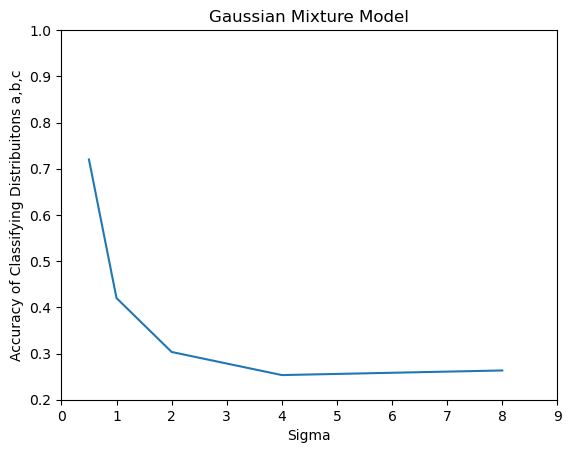

In [198]:
# Plotting Accuracy
plt.plot(sigmas,accs)
plt.xlabel("Sigma")
plt.ylabel("Accuracy of Classifying Distribuitons a,b,c")
plt.title("Gaussian Mixture Model")
plt.xticks(np.arange(0, 9.1, 1))
plt.yticks(np.arange(0.2, 1.01, .1));

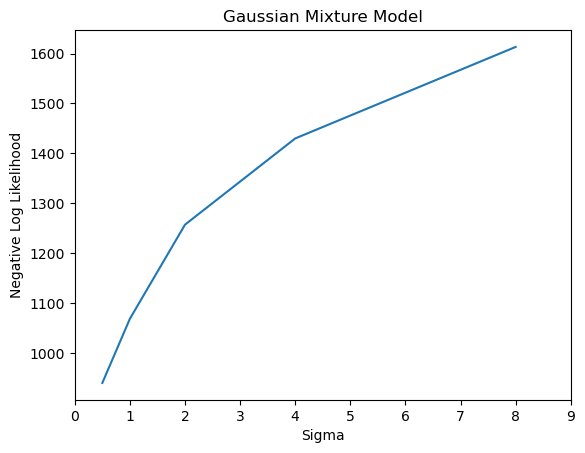

In [199]:
# Plotting Objective Values (sum of duclidean distances from datapoints to their centers)
plt.plot(sigmas,obj_vals)
plt.xlabel("Sigma")
plt.ylabel("Negative Log Likelihood")
plt.title("Gaussian Mixture Model")
plt.xticks(np.arange(0, 9.1, 1));

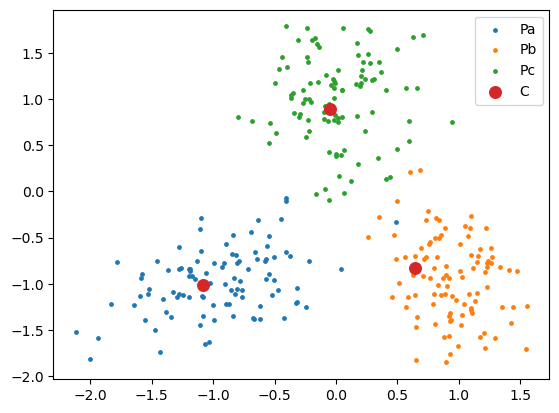

In [158]:
# Model Example
sigma=.1
x1,x2 = get_synth_data(sigma, 300)
model = GMM(max_iter=500, tol=1e-5)
model.cluster(3,x1,x2)
c = np.array(model.get_means())
plt.scatter(x1[0:100],x2[0:100],s=6,label='Pa')
plt.scatter(x1[100:200],x2[100:200],s=6,label='Pb')
plt.scatter(x1[200:300],x2[200:300],s=6,label='Pc')
plt.scatter(c[:,0],c[:,1],s=70,label='C')
plt.legend();